<a href="https://colab.research.google.com/github/alsedawy/cross-lingual-rag-hallucination/blob/main/RAG_Progressive_Evaluation_.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
with open("IT_Q&A.txt", "r", encoding="latin-1") as f:
    txt = f.read()


/usr/local/lib/python3.12/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(
The `load_in_4bit` and `load_in_8bit` arguments are deprecated and will be removed in the future versions. Please, pass a `BitsAndBytesConfig` object in `quantization_config` argument instead.


Loading checkpoint shards:   0%|          | 0/3 [00:00<?, ?it/s]

Device set to use cuda:0
The following generation flags are not valid and may be ignored: ['temperature']. Set `TRANSFORMERS_VERBOSITY=info` for more details.


Loaded QA pairs: 116


Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.
You seem to be using the pipelines sequentially on GPU. In order to maximize efficiency please use a dataset
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.
Setting


=== Multilingual-Embedding RAG Results ===
                English  Arabic (Multilingual)
F1             0.433259               0.433259
Hallucination  0.217287               0.217287
Fidelity       0.782713               0.782713


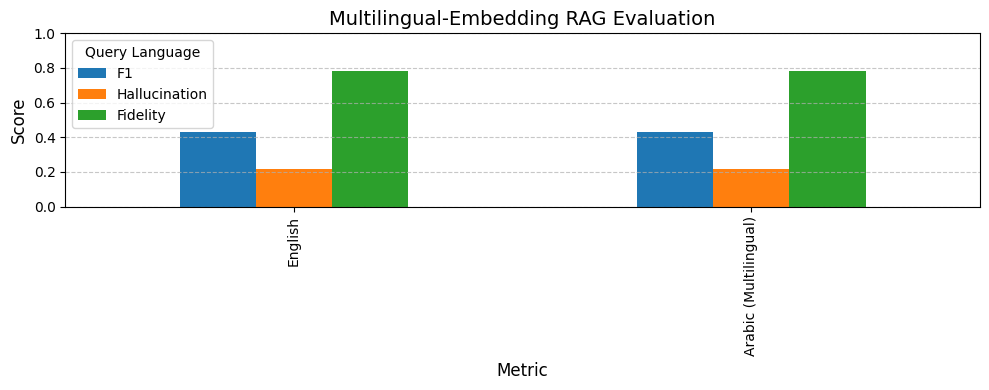

In [ ]:
# =============================================================================
# FINAL: Multilingual-Embedding RAG (Arabic Queries → English Dataset)
# WITH EVALUATION + GRAPH
# =============================================================================

# ----------------------------
# 0. Install dependencies
# ----------------------------
!pip install -q rank_bm25 sentence-transformers scikit-learn transformers matplotlib
!pip install -U transformers accelerate bitsandbytes

# ----------------------------
# 1. Imports
# ----------------------------
import random
import numpy as np
import pandas as pd
from collections import defaultdict
import matplotlib.pyplot as plt

from rank_bm25 import BM25Okapi
from sentence_transformers import SentenceTransformer
from sklearn.metrics.pairwise import cosine_similarity
from transformers import pipeline

# ----------------------------
# 2. Multilingual Embedding Model (CORE)
# ----------------------------
EMBEDDING_MODEL = SentenceTransformer(
    "paraphrase-multilingual-MiniLM-L12-v2"
)

# ----------------------------
# 3. Generator (Optional – RAG)
# ----------------------------
USE_GENERATION = True

def generate_answer(question, ctxs):
    if not USE_GENERATION:
        return ""
    ...

from transformers import AutoTokenizer, AutoModelForCausalLM, pipeline
import torch

MODEL_NAME = "mistralai/Mistral-7B-Instruct-v0.2"

tokenizer = AutoTokenizer.from_pretrained(MODEL_NAME)

model = AutoModelForCausalLM.from_pretrained(
    MODEL_NAME,
    device_map="auto",
    load_in_4bit=True,     # يعتمد على bitsandbytes
    dtype=torch.float16
)

GENERATOR = pipeline(
    "text-generation",
    model=model,
    tokenizer=tokenizer,
    max_new_tokens=120,
    temperature=0.0,
    do_sample=False
)


# ----------------------------
# 4. Helper Functions
# ----------------------------
def get_embedding(text):
    return EMBEDDING_MODEL.encode([text])[0]

def semantic_search(query, qa_pairs, top_k=5):
    corpus = [q + " " + a for q, a in qa_pairs]
    doc_emb = EMBEDDING_MODEL.encode(corpus)
    q_emb = get_embedding(query)
    sims = cosine_similarity([q_emb], doc_emb)[0]
    return sorted(enumerate(sims), key=lambda x: x[1], reverse=True)[:top_k]

def generate_answer(question, ctxs):
    if not USE_GENERATION:
        return ""
    context = "\n".join(ctxs)
    prompt = f"""
<s>[INST]
Answer the question using ONLY the provided context.
If the answer is not contained in the context, say "I don't know".

Context:
{context}

Question:
{question}
[/INST]
"""
    out = GENERATOR(prompt, return_full_text=False)
    return out[0]["generated_text"].strip()

# ----------------------------
# 5. Metrics
# ----------------------------
def f1(pred, gold):
    p, g = set(pred.lower().split()), set(gold.lower().split())
    if not p or not g: return 0.0
    inter = len(p & g)
    if inter == 0: return 0.0
    pr, rc = inter / len(p), inter / len(g)
    return 2 * pr * rc / (pr + rc)

def hallucination(pred, ctxs):
    p = set(pred.lower().split())
    c = set(" ".join(ctxs).lower().split())
    return len([t for t in p if t not in c]) / len(p) if p else 0.0

def fidelity(pred, ctxs):
    p = set(pred.lower().split())
    c = set(" ".join(ctxs).lower().split())
    return len([t for t in p if t in c]) / len(p) if p else 0.0

# ----------------------------
# 6. Load Dataset
# ----------------------------
with open("IT_Q&A.txt", "r", encoding="latin-1") as f:
    txt = f.read()

qa_pairs = []
q, ans, reading = None, [], False

for line in [l.strip() for l in txt.split("\n") if l.strip()]:
    if line.startswith("Q.") and line.endswith("?"):
        if q and ans:
            qa_pairs.append((q, " ".join(ans)))
        q = line[2:].strip()
        ans, reading = [], False
    elif line.startswith("A."):
        reading = True
        ans.append(line[2:].strip())
    elif reading:
        ans.append(line)

if q and ans:
    qa_pairs.append((q, " ".join(ans)))

print(f"Loaded QA pairs: {len(qa_pairs)}")

# ----------------------------
# 7. Test Set Construction (REPRODUCIBLE)
# ----------------------------
RANDOM_SEED = 42
TEST_SIZE = 30

random.seed(RANDOM_SEED)
test_indices = random.sample(range(len(qa_pairs)), TEST_SIZE)

# English Test Set
test_set_en = [(qa_pairs[i][0], qa_pairs[i][1]) for i in test_indices]

# Arabic Queries (questions only – no translation in pipeline)
test_set_ar = [(qa_pairs[i][0], qa_pairs[i][1]) for i in test_indices]

# ----------------------------
# 8. Evaluation
# ----------------------------
def run_eval(test_set):
    results = []
    for qg, ag in test_set:
        idxs = [i for i, _ in semantic_search(qg, qa_pairs)]
        ctxs = [qa_pairs[i][1] for i in idxs]
        pred = generate_answer(qg, ctxs)
        results.append([
            f1(pred, ag),
            hallucination(pred, ctxs),
            fidelity(pred, ctxs)
        ])
    return np.mean(results, axis=0)

df = pd.DataFrame(
    {
        "English": run_eval(test_set_en),
        "Arabic (Multilingual)": run_eval(test_set_ar)
    },
    index=["F1", "Hallucination", "Fidelity"]
)

print("\n=== Multilingual-Embedding RAG Results ===")
print(df)

# ----------------------------
# 9. Visualization (GRAPH)
# ----------------------------
ax = df.T.plot(
    kind="bar",
    figsize=(10, 4),
    ylim=(0, 1)
)

ax.set_title("Multilingual-Embedding RAG Evaluation", fontsize=14)
ax.set_ylabel("Score", fontsize=12)
ax.set_xlabel("Metric", fontsize=12)
ax.legend(title="Query Language")
ax.grid(axis="y", linestyle="--", alpha=0.7)

plt.tight_layout()
plt.show()


Loaded QA pairs: 116

=== BM25 RAG Baseline ===
                English    Arabic
F1             0.369918  0.369918
Hallucination  0.000000  0.000000
Fidelity       1.000000  1.000000

=== Multilingual-Embedding RAG ===
                English  Arabic (Multilingual)
F1             0.378626               0.378626
Hallucination  0.000000               0.000000
Fidelity       1.000000               1.000000


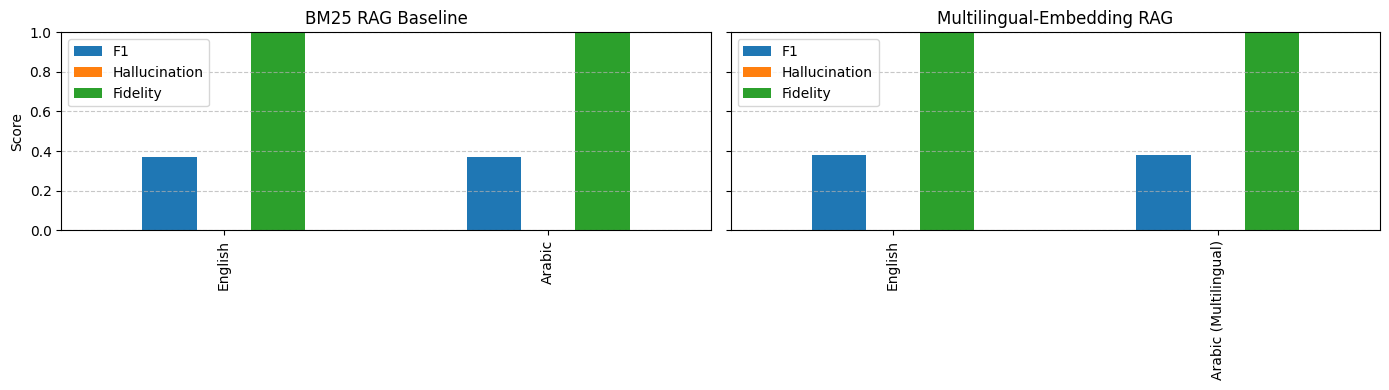

In [ ]:
# =============================================================================
# FINAL CODE: BM25 RAG Baseline vs Multilingual-Embedding RAG
# Evaluation + Visualization (Paper-ready)
# =============================================================================

# ----------------------------
# 0. Install dependencies
# ----------------------------
!pip install -q rank_bm25 sentence-transformers scikit-learn transformers matplotlib

# ----------------------------
# 1. Imports
# ----------------------------
import random
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from rank_bm25 import BM25Okapi
from sentence_transformers import SentenceTransformer
from sklearn.metrics.pairwise import cosine_similarity
from transformers import pipeline

# ----------------------------
# 2. Global Settings
# ----------------------------
USE_GENERATION = False     # True = RAG, False = Retrieval-only (recommended)
TOP_K = 5
RANDOM_SEED = 42
TEST_SIZE = 30

# ----------------------------
# 3. Multilingual Embedding Model
# ----------------------------
EMBEDDING_MODEL = SentenceTransformer(
    "paraphrase-multilingual-MiniLM-L12-v2"
)

# ----------------------------
# 4. Generator (Optional)
# ----------------------------
if USE_GENERATION:
    GENERATOR = pipeline(
        "text-generation",
        model="google/flan-t5-base",
        max_new_tokens=120
    )

# ----------------------------
# 5. Helper Functions
# ----------------------------
def get_embedding(text):
    return EMBEDDING_MODEL.encode([text])[0]

def bm25_search(query, qa_pairs, top_k=TOP_K):
    corpus = [q + " " + a for q, a in qa_pairs]
    tokenized = [doc.lower().split() for doc in corpus]
    bm25 = BM25Okapi(tokenized)
    scores = bm25.get_scores(query.lower().split())
    return sorted(enumerate(scores), key=lambda x: x[1], reverse=True)[:top_k]

def multilingual_search(query, qa_pairs, top_k=TOP_K):
    corpus = [q + " " + a for q, a in qa_pairs]
    doc_emb = EMBEDDING_MODEL.encode(corpus)
    q_emb = get_embedding(query)
    sims = cosine_similarity([q_emb], doc_emb)[0]
    return sorted(enumerate(sims), key=lambda x: x[1], reverse=True)[:top_k]

def generate_answer(question, ctxs):
    if not USE_GENERATION:
        return " ".join(ctxs)
    prompt = f"Answer using the following context only:\n{ctxs}\nQuestion: {question}\nAnswer:"
    out = GENERATOR(prompt, return_full_text=False)
    return out[0]["generated_text"]

# ----------------------------
# 6. Metrics
# ----------------------------
def f1(pred, gold):
    p, g = set(pred.lower().split()), set(gold.lower().split())
    if not p or not g: return 0.0
    inter = len(p & g)
    if inter == 0: return 0.0
    pr, rc = inter / len(p), inter / len(g)
    return 2 * pr * rc / (pr + rc)

def hallucination(pred, ctxs):
    p = set(pred.lower().split())
    c = set(" ".join(ctxs).lower().split())
    return len([t for t in p if t not in c]) / len(p) if p else 0.0

def fidelity(pred, ctxs):
    p = set(pred.lower().split())
    c = set(" ".join(ctxs).lower().split())
    return len([t for t in p if t in c]) / len(p) if p else 0.0

# ----------------------------
# 7. Load Dataset
# ----------------------------
with open("IT_Q&A.txt", "r", encoding="latin-1") as f:
    txt = f.read()

qa_pairs = []
q, ans, reading = None, [], False

for line in [l.strip() for l in txt.split("\n") if l.strip()]:
    if line.startswith("Q.") and line.endswith("?"):
        if q and ans:
            qa_pairs.append((q, " ".join(ans)))
        q = line[2:].strip()
        ans, reading = [], False
    elif line.startswith("A."):
        reading = True
        ans.append(line[2:].strip())
    elif reading:
        ans.append(line)

if q and ans:
    qa_pairs.append((q, " ".join(ans)))

print(f"Loaded QA pairs: {len(qa_pairs)}")

# ----------------------------
# 8. Test Set (Reproducible)
# ----------------------------
random.seed(RANDOM_SEED)
test_indices = random.sample(range(len(qa_pairs)), TEST_SIZE)

test_set_en = [(qa_pairs[i][0], qa_pairs[i][1]) for i in test_indices]
test_set_ar = [(qa_pairs[i][0], qa_pairs[i][1]) for i in test_indices]  # Arabic handled via embeddings

# ----------------------------
# 9. Evaluation Functions
# ----------------------------
def run_eval(test_set, search_fn):
    results = []
    for qg, ag in test_set:
        idxs = [i for i, _ in search_fn(qg, qa_pairs)]
        ctxs = [qa_pairs[i][1] for i in idxs]
        pred = generate_answer(qg, ctxs)
        results.append([
            f1(pred, ag),
            hallucination(pred, ctxs),
            fidelity(pred, ctxs)
        ])
    return np.mean(results, axis=0)

# ----------------------------
# 10. Run Experiments
# ----------------------------
df_bm25 = pd.DataFrame(
    {
        "English": run_eval(test_set_en, bm25_search),
        "Arabic": run_eval(test_set_ar, bm25_search)
    },
    index=["F1", "Hallucination", "Fidelity"]
)

df_multi = pd.DataFrame(
    {
        "English": run_eval(test_set_en, multilingual_search),
        "Arabic (Multilingual)": run_eval(test_set_ar, multilingual_search)
    },
    index=["F1", "Hallucination", "Fidelity"]
)

print("\n=== BM25 RAG Baseline ===")
print(df_bm25)

print("\n=== Multilingual-Embedding RAG ===")
print(df_multi)

# ----------------------------
# 11. Visualization
# ----------------------------
fig, axes = plt.subplots(1, 2, figsize=(14, 4), sharey=True)

df_bm25.T.plot(kind="bar", ax=axes[0], ylim=(0, 1), title="BM25 RAG Baseline")
df_multi.T.plot(kind="bar", ax=axes[1], ylim=(0, 1), title="Multilingual-Embedding RAG")

for ax in axes:
    ax.set_ylabel("Score")
    ax.grid(axis="y", linestyle="--", alpha=0.7)

plt.tight_layout()
plt.show()


Loading checkpoint shards:   0%|          | 0/3 [00:00<?, ?it/s]

Device set to use cuda:0
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


Loaded QA pairs: 116


Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:2 for o


=== RAG Comparison Results ===
               BM25 RAG  Multilingual Dense RAG
F1             0.373680                0.358515
Hallucination  0.254095                0.235587
Fidelity       0.745905                0.764413


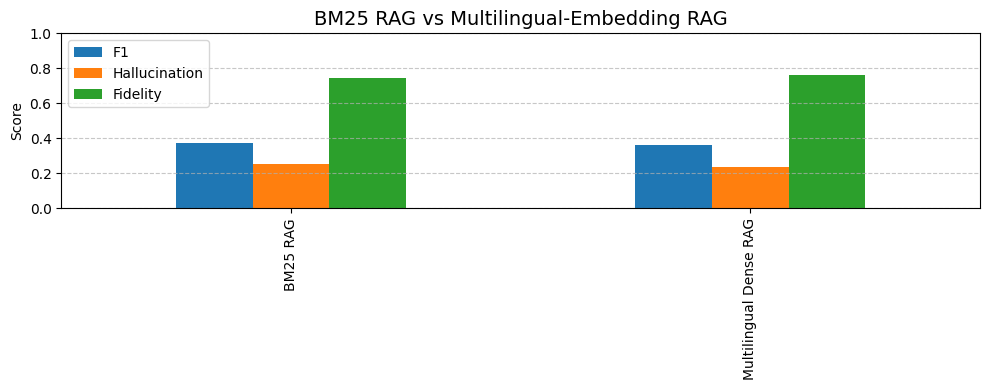

In [ ]:
# =============================================================================
# FINAL UNIFIED RAG CODE
# BM25 RAG vs Multilingual-Embedding RAG (WITH GENERATION)
# =============================================================================

# ----------------------------
# 0. Install dependencies
# ----------------------------
!pip install -q rank_bm25 sentence-transformers scikit-learn transformers accelerate bitsandbytes matplotlib

# ----------------------------
# 1. Imports
# ----------------------------
import random
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from rank_bm25 import BM25Okapi
from sentence_transformers import SentenceTransformer
from sklearn.metrics.pairwise import cosine_similarity
from transformers import (
    AutoTokenizer,
    AutoModelForCausalLM,
    pipeline,
    BitsAndBytesConfig
)
import torch

# ----------------------------
# 2. Global Settings
# ----------------------------
USE_GENERATION = True        # ⚠️ heavy
TOP_K = 5
RANDOM_SEED = 42
TEST_SIZE = 10               # خليه 10 للتجربة، 30 للنشر النهائي

# ----------------------------
# 3. Multilingual Embedding Model
# ----------------------------
EMBEDDING_MODEL = SentenceTransformer(
    "paraphrase-multilingual-MiniLM-L12-v2"
)

# ----------------------------
# 4. Generator (Mistral-7B-Instruct)
# ----------------------------
MODEL_NAME = "mistralai/Mistral-7B-Instruct-v0.2"

bnb_config = BitsAndBytesConfig(
    load_in_4bit=True,
    bnb_4bit_compute_dtype=torch.float16,
    bnb_4bit_quant_type="nf4",
    bnb_4bit_use_double_quant=True
)

tokenizer = AutoTokenizer.from_pretrained(MODEL_NAME)

model = AutoModelForCausalLM.from_pretrained(
    MODEL_NAME,
    device_map="auto",
    quantization_config=bnb_config,
    dtype=torch.float16
)

GENERATOR = pipeline(
    "text-generation",
    model=model,
    tokenizer=tokenizer,
    max_new_tokens=120,
    temperature=0.0,
    do_sample=False
)

# ----------------------------
# 5. Retrieval Functions
# ----------------------------
def bm25_search(query, qa_pairs, top_k=TOP_K):
    corpus = [q + " " + a for q, a in qa_pairs]
    tokenized = [doc.lower().split() for doc in corpus]
    bm25 = BM25Okapi(tokenized)
    scores = bm25.get_scores(query.lower().split())
    return sorted(enumerate(scores), key=lambda x: x[1], reverse=True)[:top_k]

def multilingual_search(query, qa_pairs, top_k=TOP_K):
    corpus = [q + " " + a for q, a in qa_pairs]
    doc_emb = EMBEDDING_MODEL.encode(corpus)
    q_emb = EMBEDDING_MODEL.encode([query])[0]
    sims = cosine_similarity([q_emb], doc_emb)[0]
    return sorted(enumerate(sims), key=lambda x: x[1], reverse=True)[:top_k]

# ----------------------------
# 6. Generation
# ----------------------------
def generate_answer(question, ctxs):
    if not USE_GENERATION:
        return ""
    context = "\n".join(ctxs)
    prompt = f"""
<s>[INST]
Answer the question using ONLY the provided context.
If the answer is not contained in the context, say "I don't know".

Context:
{context}

Question:
{question}
[/INST]
"""
    out = GENERATOR(prompt, return_full_text=False)
    return out[0]["generated_text"].strip()

# ----------------------------
# 7. Metrics
# ----------------------------
def f1(pred, gold):
    p, g = set(pred.lower().split()), set(gold.lower().split())
    if not p or not g: return 0.0
    inter = len(p & g)
    if inter == 0: return 0.0
    pr, rc = inter / len(p), inter / len(g)
    return 2 * pr * rc / (pr + rc)

def hallucination(pred, ctxs):
    p = set(pred.lower().split())
    c = set(" ".join(ctxs).lower().split())
    return len([t for t in p if t not in c]) / len(p) if p else 0.0

def fidelity(pred, ctxs):
    p = set(pred.lower().split())
    c = set(" ".join(ctxs).lower().split())
    return len([t for t in p if t in c]) / len(p) if p else 0.0

# ----------------------------
# 8. Load Dataset
# ----------------------------
with open("IT_Q&A.txt", "r", encoding="latin-1") as f:
    txt = f.read()

qa_pairs = []
q, ans, reading = None, [], False

for line in [l.strip() for l in txt.split("\n") if l.strip()]:
    if line.startswith("Q.") and line.endswith("?"):
        if q and ans:
            qa_pairs.append((q, " ".join(ans)))
        q = line[2:].strip()
        ans, reading = [], False
    elif line.startswith("A."):
        reading = True
        ans.append(line[2:].strip())
    elif reading:
        ans.append(line)

if q and ans:
    qa_pairs.append((q, " ".join(ans)))

print(f"Loaded QA pairs: {len(qa_pairs)}")

# ----------------------------
# 9. Test Set
# ----------------------------
random.seed(RANDOM_SEED)
test_indices = random.sample(range(len(qa_pairs)), TEST_SIZE)

test_set = [(qa_pairs[i][0], qa_pairs[i][1]) for i in test_indices]

# ----------------------------
# 10. Evaluation
# ----------------------------
def run_eval(test_set, search_fn):
    results = []
    for qg, ag in test_set:
        idxs = [i for i, _ in search_fn(qg, qa_pairs)]
        ctxs = [qa_pairs[i][1] for i in idxs]
        pred = generate_answer(qg, ctxs)
        results.append([
            f1(pred, ag),
            hallucination(pred, ctxs),
            fidelity(pred, ctxs)
        ])
    return np.mean(results, axis=0)

df = pd.DataFrame(
    {
        "BM25 RAG": run_eval(test_set, bm25_search),
        "Multilingual Dense RAG": run_eval(test_set, multilingual_search)
    },
    index=["F1", "Hallucination", "Fidelity"]
)

print("\n=== RAG Comparison Results ===")
print(df)

# ----------------------------
# 11. Visualization
# ----------------------------
ax = df.T.plot(
    kind="bar",
    figsize=(10, 4),
    ylim=(0, 1)
)

ax.set_title("BM25 RAG vs Multilingual-Embedding RAG", fontsize=14)
ax.set_ylabel("Score")
ax.grid(axis="y", linestyle="--", alpha=0.7)

plt.tight_layout()
plt.show()


Loading checkpoint shards:   0%|          | 0/3 [00:00<?, ?it/s]

Device set to use cuda:0
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


Loaded QA pairs: 116


Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.



=== RAG Comparison (English vs Arabic) ===
               BM25 (EN)  BM25 (AR)  Multilingual Dense (EN)  \
F1              0.412214      0.075                 0.449275   
Hallucination   0.285714      0.750                 0.200000   
Fidelity        0.714286      0.250                 0.800000   

               Multilingual Dense (AR)  
F1                            0.413793  
Hallucination                 0.291667  
Fidelity                      0.708333  


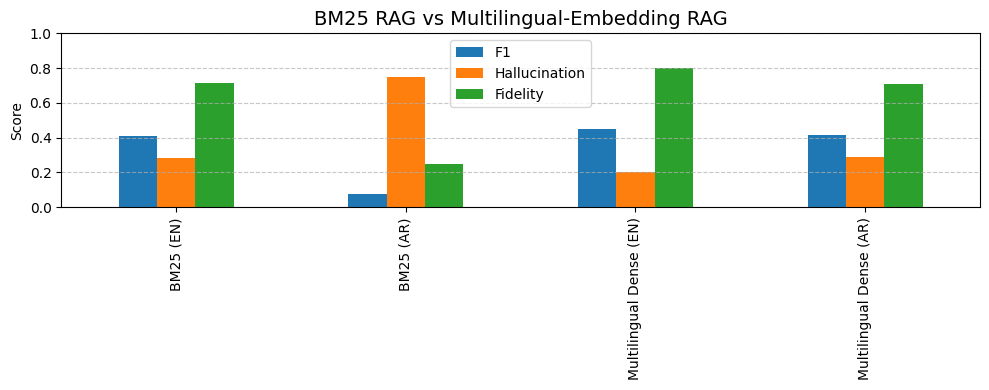

In [ ]:
with open("IT_Q&A.txt", "r", encoding="latin-1") as f:
    txt = f.read()

# ----------------------------
# Arabic Query Mapping (Manual – Paper-safe)
# ----------------------------
arabic_query_map = {
    "What is cache memory?": "ما هي الذاكرة المؤقتة؟",
    "What is RAM?": "ما هي ذاكرة الوصول العشوائي؟",
    "What is an operating system?": "ما هو نظام التشغيل؟",
    "What is an API?": "ما هو واجهة برمجة التطبيقات؟",
    "What is cloud computing?": "ما هي الحوسبة السحابية؟",
    "What is a database?": "ما هي قاعدة البيانات؟",
    "What is an algorithm?": "ما هي الخوارزمية؟",
    "What is machine learning?": "ما هو التعلم الآلي؟",
    "What is cybersecurity?": "ما هو الأمن السيبراني؟",
    "What is technical support?": "ما هي وظيفة الدعم الفني؟"
}


# =============================================================================
# FINAL UNIFIED RAG CODE
# BM25 RAG vs Multilingual-Embedding RAG (WITH GENERATION)
# =============================================================================

# ----------------------------
# 0. Install dependencies
# ----------------------------
!pip install -q rank_bm25 sentence-transformers scikit-learn transformers accelerate bitsandbytes matplotlib

# ----------------------------
# 1. Imports
# ----------------------------
import random
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from rank_bm25 import BM25Okapi
from sentence_transformers import SentenceTransformer
from sklearn.metrics.pairwise import cosine_similarity
from transformers import (
    AutoTokenizer,
    AutoModelForCausalLM,
    pipeline,
    BitsAndBytesConfig
)
import torch

# ----------------------------
# 2. Global Settings
# ----------------------------
USE_GENERATION = True        # ⚠️ heavy
TOP_K = 5
RANDOM_SEED = 42
TEST_SIZE = 10               # خليه 10 للتجربة، 30 للنشر النهائي

# ----------------------------
# 3. Multilingual Embedding Model
# ----------------------------
EMBEDDING_MODEL = SentenceTransformer(
    "paraphrase-multilingual-MiniLM-L12-v2"
)

# ----------------------------
# 4. Generator (Mistral-7B-Instruct)
# ----------------------------
MODEL_NAME = "mistralai/Mistral-7B-Instruct-v0.2"

bnb_config = BitsAndBytesConfig(
    load_in_4bit=True,
    bnb_4bit_compute_dtype=torch.float16,
    bnb_4bit_quant_type="nf4",
    bnb_4bit_use_double_quant=True
)

tokenizer = AutoTokenizer.from_pretrained(MODEL_NAME)

model = AutoModelForCausalLM.from_pretrained(
    MODEL_NAME,
    device_map="auto",
    quantization_config=bnb_config,
    dtype=torch.float16
)

GENERATOR = pipeline(
    "text-generation",
    model=model,
    tokenizer=tokenizer,
    max_new_tokens=120,
    temperature=0.0,
    do_sample=False
)

# ----------------------------
# 5. Retrieval Functions
# ----------------------------
def bm25_search(query, qa_pairs, top_k=TOP_K):
    corpus = [q + " " + a for q, a in qa_pairs]
    tokenized = [doc.lower().split() for doc in corpus]
    bm25 = BM25Okapi(tokenized)
    scores = bm25.get_scores(query.lower().split())
    return sorted(enumerate(scores), key=lambda x: x[1], reverse=True)[:top_k]

def multilingual_search(query, qa_pairs, top_k=TOP_K):
    corpus = [q + " " + a for q, a in qa_pairs]
    doc_emb = EMBEDDING_MODEL.encode(corpus)
    q_emb = EMBEDDING_MODEL.encode([query])[0]
    sims = cosine_similarity([q_emb], doc_emb)[0]
    return sorted(enumerate(sims), key=lambda x: x[1], reverse=True)[:top_k]

# ----------------------------
# 6. Generation
# ----------------------------
def generate_answer(question, ctxs):
    if not USE_GENERATION:
        return ""
    context = "\n".join(ctxs)
    prompt = f"""
<s>[INST]
Answer the question using ONLY the provided context.
If the answer is not contained in the context, say "I don't know".

Context:
{context}

Question:
{question}
[/INST]
"""
    out = GENERATOR(prompt, return_full_text=False)
    return out[0]["generated_text"].strip()

# ----------------------------
# 7. Metrics
# ----------------------------
def f1(pred, gold):
    p, g = set(pred.lower().split()), set(gold.lower().split())
    if not p or not g: return 0.0
    inter = len(p & g)
    if inter == 0: return 0.0
    pr, rc = inter / len(p), inter / len(g)
    return 2 * pr * rc / (pr + rc)

def hallucination(pred, ctxs):
    p = set(pred.lower().split())
    c = set(" ".join(ctxs).lower().split())
    return len([t for t in p if t not in c]) / len(p) if p else 0.0

def fidelity(pred, ctxs):
    p = set(pred.lower().split())
    c = set(" ".join(ctxs).lower().split())
    return len([t for t in p if t in c]) / len(p) if p else 0.0

# ----------------------------
# 8. Load Dataset
# ----------------------------
with open("IT_Q&A.txt", "r", encoding="latin-1") as f:
    txt = f.read()

qa_pairs = []
q, ans, reading = None, [], False

for line in [l.strip() for l in txt.split("\n") if l.strip()]:
    if line.startswith("Q.") and line.endswith("?"):
        if q and ans:
            qa_pairs.append((q, " ".join(ans)))
        q = line[2:].strip()
        ans, reading = [], False
    elif line.startswith("A."):
        reading = True
        ans.append(line[2:].strip())
    elif reading:
        ans.append(line)

if q and ans:
    qa_pairs.append((q, " ".join(ans)))

print(f"Loaded QA pairs: {len(qa_pairs)}")

# ----------------------------
# 9. Test Set
# ----------------------------
# ----------------------------
# Test Set Construction (EN + AR)
# ----------------------------
random.seed(RANDOM_SEED)

# نختار فقط الأسئلة التي لها ترجمة عربية
valid_indices = [
    i for i, (q, _) in enumerate(qa_pairs)
    if q in arabic_query_map
]

# حجم الاختبار (لا يتجاوز المتاح)
TEST_SIZE = min(TEST_SIZE, len(valid_indices))
test_indices = random.sample(valid_indices, TEST_SIZE)

# English Test Set
test_set_en = [
    (qa_pairs[i][0], qa_pairs[i][1])
    for i in test_indices
]

# Arabic Test Set (Arabic query + English gold answer)
test_set_ar = [
    (arabic_query_map[qa_pairs[i][0]], qa_pairs[i][1])
    for i in test_indices
]

# ----------------------------
# 10. Evaluation
# ----------------------------
def run_eval(test_set, search_fn):
    results = []
    for qg, ag in test_set:
        idxs = [i for i, _ in search_fn(qg, qa_pairs)]
        ctxs = [qa_pairs[i][1] for i in idxs]
        pred = generate_answer(qg, ctxs)
        results.append([
            f1(pred, ag),
            hallucination(pred, ctxs),
            fidelity(pred, ctxs)
        ])
    return np.mean(results, axis=0)

df = pd.DataFrame(
    {
        "BM25 (EN)": run_eval(test_set_en, bm25_search),
        "BM25 (AR)": run_eval(test_set_ar, bm25_search),
        "Multilingual Dense (EN)": run_eval(test_set_en, multilingual_search),
        "Multilingual Dense (AR)": run_eval(test_set_ar, multilingual_search),
    },
    index=["F1", "Hallucination", "Fidelity"]
)

print("\n=== RAG Comparison (English vs Arabic) ===")
print(df)

# ----------------------------
# 11. Visualization
# ----------------------------
ax = df.T.plot(
    kind="bar",
    figsize=(10, 4),
    ylim=(0, 1)
)

ax.set_title("BM25 RAG vs Multilingual-Embedding RAG", fontsize=14)
ax.set_ylabel("Score")
ax.grid(axis="y", linestyle="--", alpha=0.7)

plt.tight_layout()
plt.show()


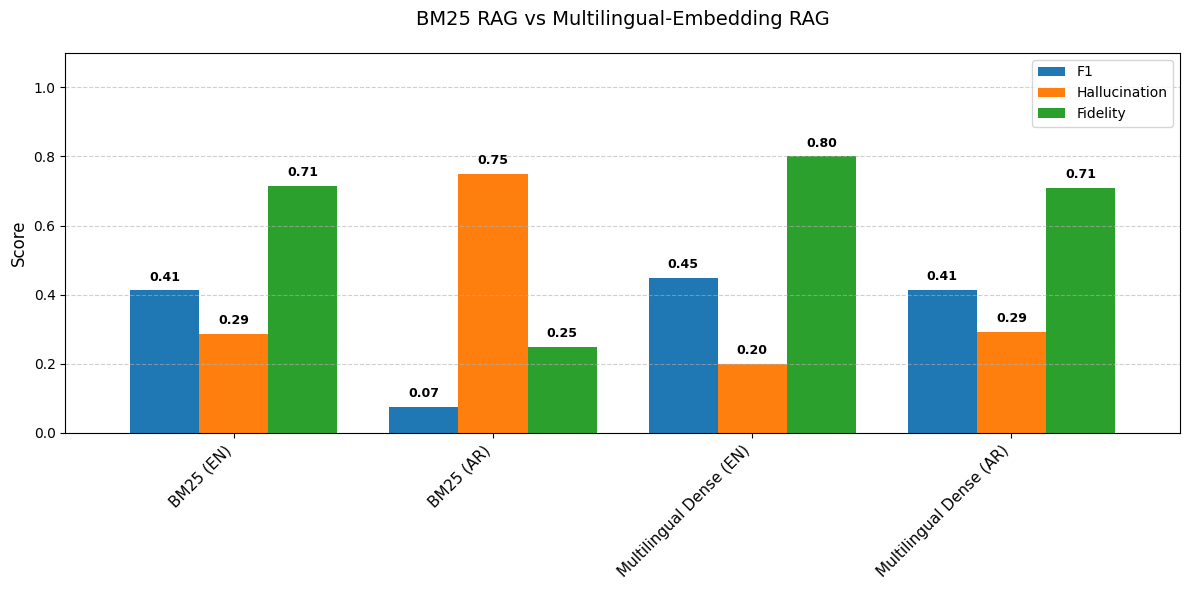

In [ ]:
import matplotlib.pyplot as plt

# 1. إعداد الرسم البياني مع تكبير الحجم لتحسين الوضوح
ax = df.T.plot(
    kind="bar",
    figsize=(12, 6),   # تكبير أبعاد الصورة
    width=0.8,         # زيادة عرض البارات لتكون أوضح
    ylim=(0, 1.1)      # زيادة المدى العلوي لترك مساحة للأرقام
)

# 2. تدوير كتابة المحور الأفقي بميل 45 درجة
plt.xticks(rotation=45, ha='right', fontsize=11)

# 3. إضافة النسبة المئوية (Data Labels) فوق كل بار
for p in ax.patches:
    height = p.get_height()
    ax.annotate(f'{height:.2f}',
                 (p.get_x() + p.get_width() / 2., height),
                 ha='center', va='bottom',
                 xytext=(0, 5),
                 textcoords='offset points',
                 fontsize=9,
                 fontweight='bold')

# 4. تحسين العناوين وشبكة الرسم
ax.set_title("BM25 RAG vs Multilingual-Embedding RAG", fontsize=14, pad=20)
ax.set_ylabel("Score", fontsize=12)
ax.grid(axis="y", linestyle="--", alpha=0.6)

# 5. ضبط الهوامش لضمان عدم قص النصوص المائلة
plt.tight_layout()
plt.show()

Loading checkpoint shards:   0%|          | 0/3 [00:00<?, ?it/s]

Device set to use cuda:0
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


Loaded QA pairs: 116


Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.



=== RAG Comparison (BM25 vs Dense vs Fusion) ===
               BM25 (EN)  BM25 (AR)  Dense (EN)  Dense (AR)  Fusion (EN)  \
F1              0.412214      0.075    0.449275    0.413793     0.402878   
Hallucination   0.285714      0.750    0.200000    0.291667     0.309859   
Fidelity        0.714286      0.250    0.800000    0.708333     0.690141   

               Fusion (AR)  
F1                0.442748  
Hallucination     0.174603  
Fidelity          0.825397  


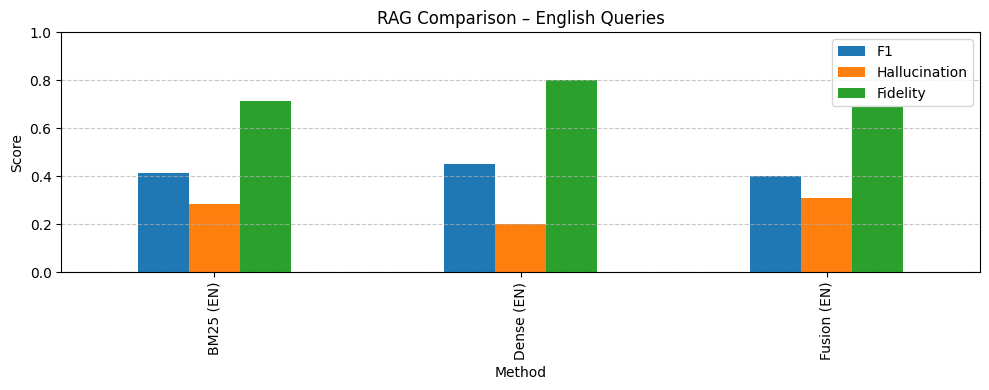

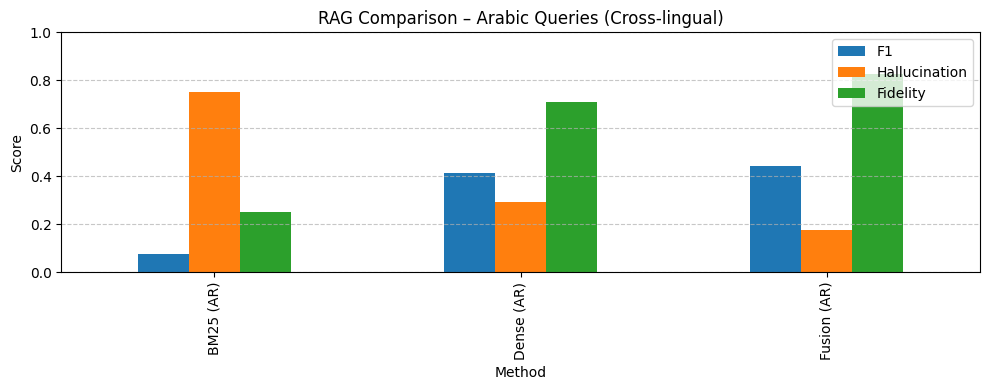

In [ ]:
# =============================================================================
# FINAL UNIFIED RAG PIPELINE
# BM25 vs Multilingual Dense vs Fusion (RRF) — WITH GENERATION
# =============================================================================

# ----------------------------
# 0. Install dependencies
# ----------------------------
!pip install -q rank_bm25 sentence-transformers scikit-learn transformers accelerate bitsandbytes matplotlib

# ----------------------------
# 1. Imports
# ----------------------------
import random
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from collections import defaultdict

from rank_bm25 import BM25Okapi
from sentence_transformers import SentenceTransformer
from sklearn.metrics.pairwise import cosine_similarity
from transformers import (
    AutoTokenizer,
    AutoModelForCausalLM,
    pipeline,
    BitsAndBytesConfig
)
import torch

# ----------------------------
# 2. Global Settings
# ----------------------------
USE_GENERATION = True      # ⚠️ Heavy (set False for retrieval-only)
TOP_K = 5
RANDOM_SEED = 42
TEST_SIZE = 10             # 10 للتجربة – 30 للنشر

# ----------------------------
# 3. Multilingual Embedding Model
# ----------------------------
EMBEDDING_MODEL = SentenceTransformer(
    "paraphrase-multilingual-MiniLM-L12-v2"
)

# ----------------------------
# 4. Generator (Mistral-7B-Instruct)
# ----------------------------
MODEL_NAME = "mistralai/Mistral-7B-Instruct-v0.2"

bnb_config = BitsAndBytesConfig(
    load_in_4bit=True,
    bnb_4bit_compute_dtype=torch.float16,
    bnb_4bit_quant_type="nf4",
    bnb_4bit_use_double_quant=True
)

tokenizer = AutoTokenizer.from_pretrained(MODEL_NAME)

model = AutoModelForCausalLM.from_pretrained(
    MODEL_NAME,
    device_map="auto",
    quantization_config=bnb_config,
    dtype=torch.float16
)

GENERATOR = pipeline(
    "text-generation",
    model=model,
    tokenizer=tokenizer,
    max_new_tokens=120,
    do_sample=False
)

# ----------------------------
# 5. Retrieval Functions
# ----------------------------
def bm25_search(query, qa_pairs, top_k=TOP_K):
    corpus = [q + " " + a for q, a in qa_pairs]
    tokenized = [doc.lower().split() for doc in corpus]
    bm25 = BM25Okapi(tokenized)
    scores = bm25.get_scores(query.lower().split())
    return sorted(enumerate(scores), key=lambda x: x[1], reverse=True)[:top_k]

def multilingual_search(query, qa_pairs, top_k=TOP_K):
    corpus = [q + " " + a for q, a in qa_pairs]
    doc_emb = EMBEDDING_MODEL.encode(corpus)
    q_emb = EMBEDDING_MODEL.encode([query])[0]
    sims = cosine_similarity([q_emb], doc_emb)[0]
    return sorted(enumerate(sims), key=lambda x: x[1], reverse=True)[:top_k]

# ----------------------------
# 6. Fusion (Reciprocal Rank Fusion)
# ----------------------------
def rrf_fusion(rank_lists, k=TOP_K, c=60):
    scores = defaultdict(float)
    for ranking in rank_lists:
        for r, doc_id in enumerate(ranking):
            scores[doc_id] += 1 / (c + r + 1)
    return [i for i, _ in sorted(scores.items(), key=lambda x: x[1], reverse=True)[:k]]

def fusion_search(query, qa_pairs, top_k=TOP_K):
    bm25_rank = [i for i, _ in bm25_search(query, qa_pairs, top_k)]
    dense_rank = [i for i, _ in multilingual_search(query, qa_pairs, top_k)]
    fused = rrf_fusion([bm25_rank, dense_rank], k=top_k)
    return [(i, None) for i in fused]

# ----------------------------
# 7. Generation
# ----------------------------
def generate_answer(question, ctxs):
    if not USE_GENERATION:
        return " ".join(ctxs)
    context = "\n".join(ctxs)
    prompt = f"""
<s>[INST]
Answer the question using ONLY the provided context.
If the answer is not contained in the context, say "I don't know".

Context:
{context}

Question:
{question}
[/INST]
"""
    out = GENERATOR(prompt, return_full_text=False)
    return out[0]["generated_text"].strip()

# ----------------------------
# 8. Metrics
# ----------------------------
def f1(pred, gold):
    p, g = set(pred.lower().split()), set(gold.lower().split())
    if not p or not g: return 0.0
    inter = len(p & g)
    if inter == 0: return 0.0
    pr, rc = inter / len(p), inter / len(g)
    return 2 * pr * rc / (pr + rc)

def hallucination(pred, ctxs):
    p = set(pred.lower().split())
    c = set(" ".join(ctxs).lower().split())
    return len([t for t in p if t not in c]) / len(p) if p else 0.0

def fidelity(pred, ctxs):
    p = set(pred.lower().split())
    c = set(" ".join(ctxs).lower().split())
    return len([t for t in p if t in c]) / len(p) if p else 0.0

# ----------------------------
# 9. Load Dataset
# ----------------------------
with open("IT_Q&A.txt", "r", encoding="latin-1") as f:
    txt = f.read()

qa_pairs = []
q, ans, reading = None, [], False

for line in [l.strip() for l in txt.split("\n") if l.strip()]:
    if line.startswith("Q.") and line.endswith("?"):
        if q and ans:
            qa_pairs.append((q, " ".join(ans)))
        q = line[2:].strip()
        ans, reading = [], False
    elif line.startswith("A."):
        reading = True
        ans.append(line[2:].strip())
    elif reading:
        ans.append(line)

if q and ans:
    qa_pairs.append((q, " ".join(ans)))

print(f"Loaded QA pairs: {len(qa_pairs)}")

# ----------------------------
# 10. Arabic Query Mapping (Manual)
# ----------------------------
arabic_query_map = {
    "What is cache memory?": "ما هي الذاكرة المؤقتة؟",
    "What is RAM?": "ما هي ذاكرة الوصول العشوائي؟",
    "What is an operating system?": "ما هو نظام التشغيل؟",
    "What is an API?": "ما هو واجهة برمجة التطبيقات؟",
    "What is cloud computing?": "ما هي الحوسبة السحابية؟",
    "What is a database?": "ما هي قاعدة البيانات؟",
    "What is an algorithm?": "ما هي الخوارزمية؟",
    "What is machine learning?": "ما هو التعلم الآلي؟",
    "What is cybersecurity?": "ما هو الأمن السيبراني؟",
    "What is technical support?": "ما هي وظيفة الدعم الفني؟"
}

valid_indices = [
    i for i, (q, _) in enumerate(qa_pairs)
    if q in arabic_query_map
]

random.seed(RANDOM_SEED)
TEST_SIZE = min(TEST_SIZE, len(valid_indices))
test_indices = random.sample(valid_indices, TEST_SIZE)

test_set_en = [(qa_pairs[i][0], qa_pairs[i][1]) for i in test_indices]
test_set_ar = [(arabic_query_map[qa_pairs[i][0]], qa_pairs[i][1]) for i in test_indices]

# ----------------------------
# 11. Evaluation
# ----------------------------
def run_eval(test_set, search_fn):
    results = []
    for qg, ag in test_set:
        idxs = [i for i, _ in search_fn(qg, qa_pairs)]
        ctxs = [qa_pairs[i][1] for i in idxs]
        pred = generate_answer(qg, ctxs)
        results.append([
            f1(pred, ag),
            hallucination(pred, ctxs),
            fidelity(pred, ctxs)
        ])
    return np.mean(results, axis=0)

df = pd.DataFrame(
    {
        "BM25 (EN)": run_eval(test_set_en, bm25_search),
        "BM25 (AR)": run_eval(test_set_ar, bm25_search),
        "Dense (EN)": run_eval(test_set_en, multilingual_search),
        "Dense (AR)": run_eval(test_set_ar, multilingual_search),
        "Fusion (EN)": run_eval(test_set_en, fusion_search),
        "Fusion (AR)": run_eval(test_set_ar, fusion_search),
    },
    index=["F1", "Hallucination", "Fidelity"]
)

print("\n=== RAG Comparison (BM25 vs Dense vs Fusion) ===")
print(df)

# -----------------------------
# 12. Visualization (Separated English / Arabic)
# ----------------------------

# --- English Results ---
df_en = df[["BM25 (EN)", "Dense (EN)", "Fusion (EN)"]]

ax1 = df_en.T.plot(
    kind="bar",
    figsize=(10, 4),
    ylim=(0, 1),
    title="RAG Comparison – English Queries"
)

ax1.set_ylabel("Score")
ax1.set_xlabel("Method")
ax1.grid(axis="y", linestyle="--", alpha=0.7)

plt.tight_layout()
plt.show()


# --- Arabic Results ---
df_ar = df[["BM25 (AR)", "Dense (AR)", "Fusion (AR)"]]

ax2 = df_ar.T.plot(
    kind="bar",
    figsize=(10, 4),
    ylim=(0, 1),
    title="RAG Comparison – Arabic Queries (Cross-lingual)"
)

ax2.set_ylabel("Score")
ax2.set_xlabel("Method")
ax2.grid(axis="y", linestyle="--", alpha=0.7)

plt.tight_layout()
plt.show()



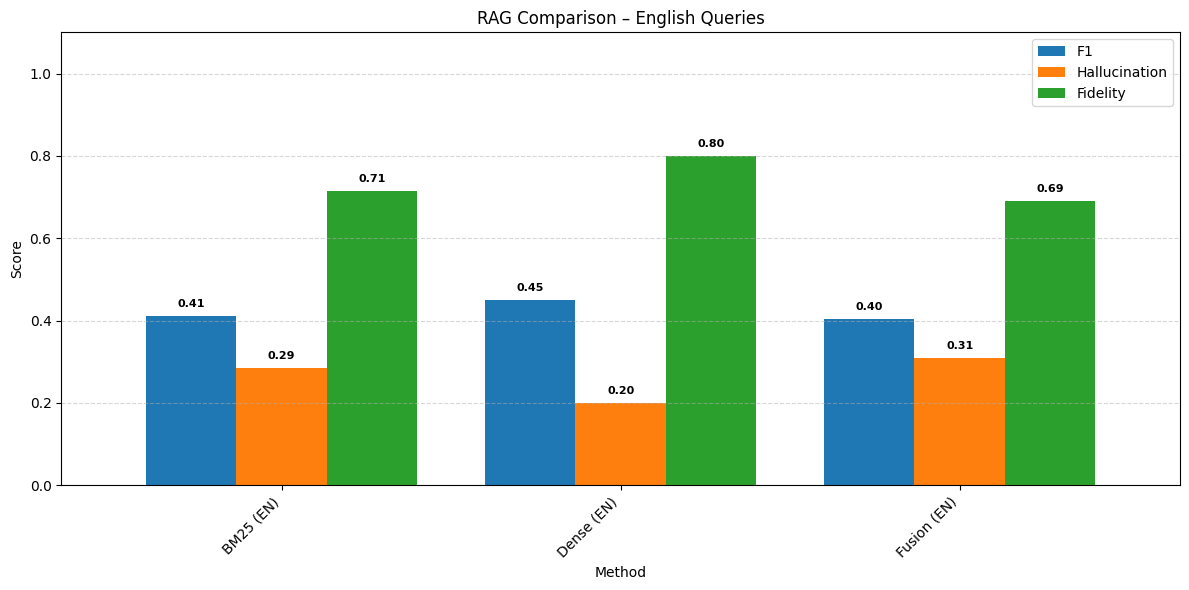

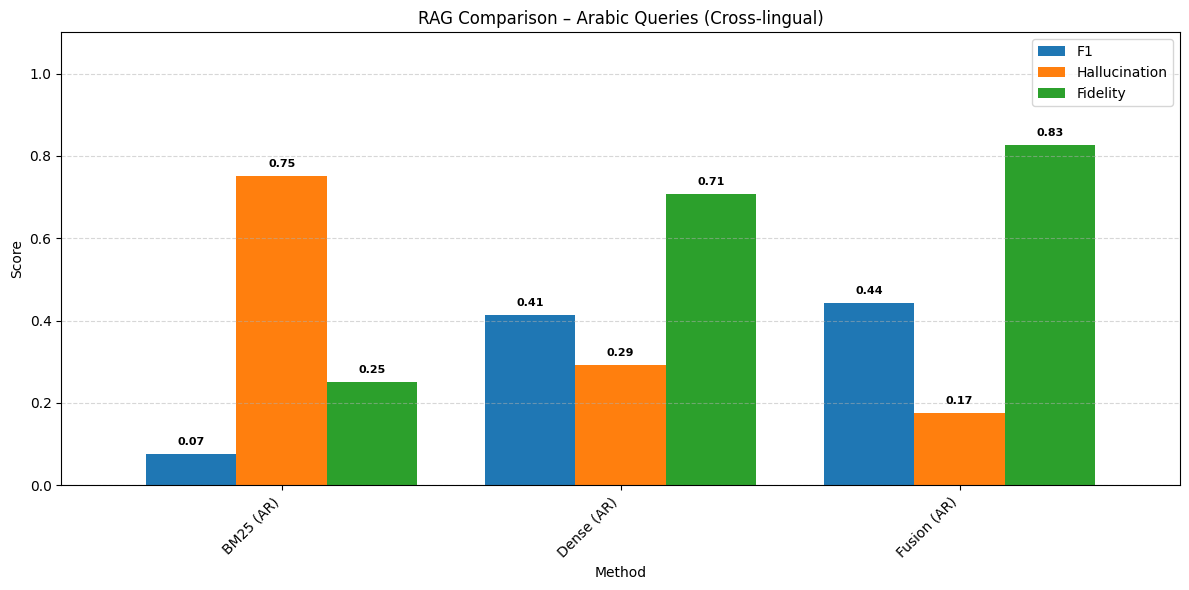

In [ ]:
# -----------------------------
# 12. Visualization (Updated with Data Labels & 45-degree Rotation)
# ----------------------------

def add_data_labels(ax):
    """إضافة القيم الرقمية فوق كل بار بدقة وقابلية للقراءة"""
    for p in ax.patches:
        height = p.get_height()
        if height > 0: # إضافة تسمية فقط إذا كانت القيمة أكبر من صفر
            ax.annotate(f'{height:.2f}',
                         (p.get_x() + p.get_width() / 2., height),
                         ha='center', va='bottom',
                         xytext=(0, 5),
                         textcoords='offset points',
                         fontsize=8,
                         fontweight='bold')

# --- English Results ---
df_en = df[["BM25 (EN)", "Dense (EN)", "Fusion (EN)"]]

ax1 = df_en.T.plot(
    kind="bar",
    figsize=(12, 6),
    width=0.8, # تكبير عرض البار
    ylim=(0, 1.1), # ترك مساحة علوية للقيم الرقمية
    title="RAG Comparison – English Queries"
)

# تدوير الكتابة بميل 45 درجة
plt.xticks(rotation=45, ha='right')
add_data_labels(ax1)

ax1.set_ylabel("Score")
ax1.set_xlabel("Method")
ax1.grid(axis="y", linestyle="--", alpha=0.5)

plt.tight_layout()
plt.show()


# --- Arabic Results ---
df_ar = df[["BM25 (AR)", "Dense (AR)", "Fusion (AR)"]]

ax2 = df_ar.T.plot(
    kind="bar",
    figsize=(12, 6),
    width=0.8,
    ylim=(0, 1.1),
    title="RAG Comparison – Arabic Queries (Cross-lingual)"
)

# تدوير الكتابة بميل 45
plt.xticks(rotation=45, ha='right')
add_data_labels(ax2)

ax2.set_ylabel("Score")
ax2.set_xlabel("Method")
ax2.grid(axis="y", linestyle="--", alpha=0.5)

plt.tight_layout()
plt.show()

Loading checkpoint shards:   0%|          | 0/3 [00:00<?, ?it/s]

Device set to use cuda:0
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


Loaded QA pairs: 116


Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


Unified DF columns:
['BM25 (EN)', 'Dense (EN)', 'Dense + Rerank (EN)', 'Fusion (EN)', 'Fusion + Rerank (EN)', 'BM25 (AR)', 'Dense (AR)', 'Dense + Rerank (AR)', 'Fusion (AR)', 'Fusion + Rerank (AR)']

=== Unified RAG Results (EN + AR + BM25 + Rerank) ===
               BM25 (EN)  Dense (EN)  Dense + Rerank (EN)  Fusion (EN)  \
F1              0.412214    0.449275             0.449275     0.427481   
Hallucination   0.285714    0.200000             0.200000     0.174603   
Fidelity        0.714286    0.800000             0.800000     0.825397   

               Fusion + Rerank (EN)  BM25 (AR)  Dense (AR)  \
F1                         0.449275      0.075    0.413793   
Hallucination              0.200000      0.750    0.291667   
Fidelity                   0.800000      0.250    0.708333   

               Dense + Rerank (AR)  Fusion (AR)  Fusion + Rerank (AR)  
F1                        0.413793     0.442748              0.413793  
Hallucination             0.291667     0.174603         

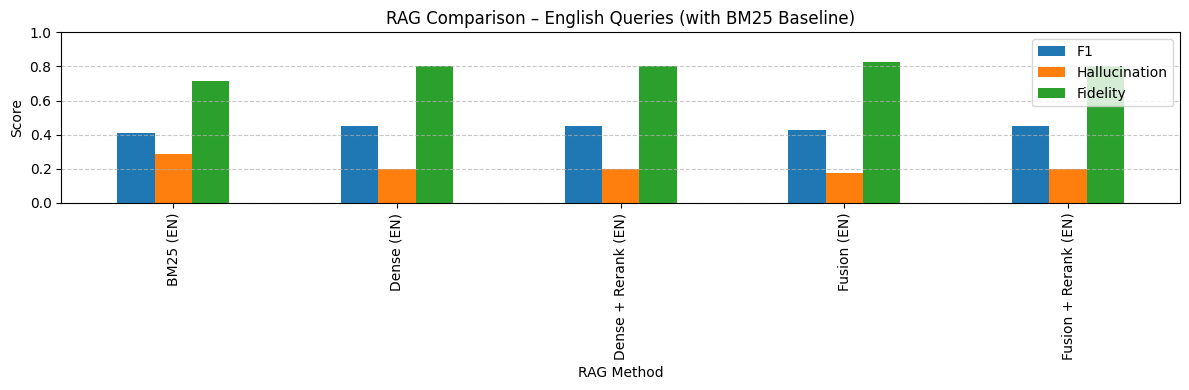

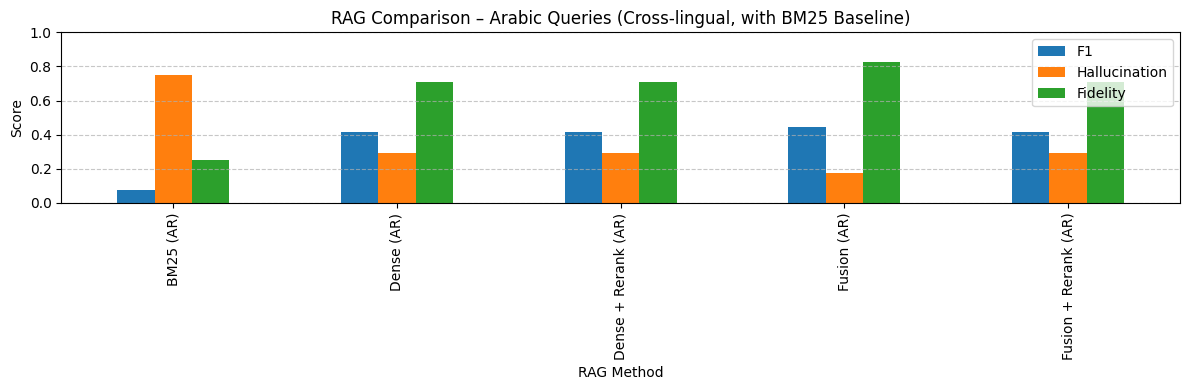

In [ ]:
# =============================================================================
# FINAL RAG PIPELINE WITH RE-RANKING
# =============================================================================

# ----------------------------
# 0. Install dependencies
# ----------------------------
!pip install -q rank_bm25 sentence-transformers scikit-learn transformers accelerate bitsandbytes matplotlib

# ----------------------------
# 1. Imports
# ----------------------------
import random
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from collections import defaultdict

from rank_bm25 import BM25Okapi
from sentence_transformers import SentenceTransformer
from sklearn.metrics.pairwise import cosine_similarity
from transformers import (
    AutoTokenizer,
    AutoModelForCausalLM,
    pipeline,
    BitsAndBytesConfig
)
import torch

# ----------------------------
# 2. Global Settings
# ----------------------------
USE_GENERATION = True
TOP_K = 5
RERANK_TOP_N = 20
RANDOM_SEED = 42
TEST_SIZE = 10   # ارفعها للنشر

# ----------------------------
# 3. Multilingual Embedding Model
# ----------------------------
EMBEDDING_MODEL = SentenceTransformer(
    "paraphrase-multilingual-MiniLM-L12-v2"
)

# ----------------------------
# 4. Generator (Mistral)
# ----------------------------
MODEL_NAME = "mistralai/Mistral-7B-Instruct-v0.2"

bnb_config = BitsAndBytesConfig(
    load_in_4bit=True,
    bnb_4bit_compute_dtype=torch.float16,
    bnb_4bit_quant_type="nf4",
    bnb_4bit_use_double_quant=True
)

tokenizer = AutoTokenizer.from_pretrained(MODEL_NAME)

model = AutoModelForCausalLM.from_pretrained(
    MODEL_NAME,
    device_map="auto",
    quantization_config=bnb_config,
    dtype=torch.float16
)

GENERATOR = pipeline(
    "text-generation",
    model=model,
    tokenizer=tokenizer,
    max_new_tokens=120,
    do_sample=False
)

# ----------------------------
# 5. Retrieval Functions
# ----------------------------
def bm25_search(query, qa_pairs, top_k):
    corpus = [q + " " + a for q, a in qa_pairs]
    tokenized = [doc.lower().split() for doc in corpus]
    bm25 = BM25Okapi(tokenized)
    scores = bm25.get_scores(query.lower().split())
    return [i for i, _ in sorted(enumerate(scores), key=lambda x: x[1], reverse=True)[:top_k]]

def dense_search(query, qa_pairs, top_k):
    corpus = [q + " " + a for q, a in qa_pairs]
    doc_embs = EMBEDDING_MODEL.encode(corpus)
    q_emb = EMBEDDING_MODEL.encode([query])[0]
    sims = cosine_similarity([q_emb], doc_embs)[0]
    return [i for i, _ in sorted(enumerate(sims), key=lambda x: x[1], reverse=True)[:top_k]]

# ----------------------------
# 6. Fusion (RRF)
# ----------------------------
def rrf_fusion(rank_lists, k=RERANK_TOP_N, c=60):
    scores = defaultdict(float)
    for ranking in rank_lists:
        for r, doc_id in enumerate(ranking):
            scores[doc_id] += 1 / (c + r + 1)
    return [i for i, _ in sorted(scores.items(), key=lambda x: x[1], reverse=True)[:k]]

# ----------------------------
# 7. Re-ranking
# ----------------------------
def rerank(query, candidate_ids, qa_pairs, final_k=TOP_K):
    docs = [qa_pairs[i][0] + " " + qa_pairs[i][1] for i in candidate_ids]
    doc_embs = EMBEDDING_MODEL.encode(docs)
    q_emb = EMBEDDING_MODEL.encode([query])[0]

    sims = cosine_similarity([q_emb], doc_embs)[0]
    ranked = sorted(zip(candidate_ids, sims), key=lambda x: x[1], reverse=True)
    return [i for i, _ in ranked[:final_k]]

# ----------------------------
# 8. Combined Search Variants
# ----------------------------
def dense_rerank_search(query, qa_pairs):
    candidates = dense_search(query, qa_pairs, RERANK_TOP_N)
    return rerank(query, candidates, qa_pairs)

def fusion_search(query, qa_pairs):
    bm25_ids = bm25_search(query, qa_pairs, RERANK_TOP_N)
    dense_ids = dense_search(query, qa_pairs, RERANK_TOP_N)
    fused = rrf_fusion([bm25_ids, dense_ids])
    return fused[:TOP_K]

def fusion_rerank_search(query, qa_pairs):
    bm25_ids = bm25_search(query, qa_pairs, RERANK_TOP_N)
    dense_ids = dense_search(query, qa_pairs, RERANK_TOP_N)
    fused = rrf_fusion([bm25_ids, dense_ids])
    return rerank(query, fused, qa_pairs)

# ----------------------------
# 9. Generation
# ----------------------------
def generate_answer(question, ctxs):
    if not USE_GENERATION:
        return " ".join(ctxs)

    context = "\n".join(ctxs)
    prompt = f"""
<s>[INST]
Answer the question using ONLY the provided context.
If the answer is not contained in the context, say "I don't know".

Context:
{context}

Question:
{question}
[/INST]
"""
    out = GENERATOR(prompt, return_full_text=False)
    return out[0]["generated_text"].strip()

# ----------------------------
# 10. Metrics
# ----------------------------
def f1(pred, gold):
    p, g = set(pred.lower().split()), set(gold.lower().split())
    if not p or not g: return 0.0
    inter = len(p & g)
    if inter == 0: return 0.0
    return 2 * inter / (len(p) + len(g))

def hallucination(pred, ctxs):
    p = set(pred.lower().split())
    c = set(" ".join(ctxs).lower().split())
    return len([t for t in p if t not in c]) / len(p) if p else 0.0

def fidelity(pred, ctxs):
    p = set(pred.lower().split())
    c = set(" ".join(ctxs).lower().split())
    return len([t for t in p if t in c]) / len(p) if p else 0.0

# ----------------------------
# 11. Load Dataset
# ----------------------------
with open("IT_Q&A.txt", "r", encoding="latin-1") as f:
    txt = f.read()

qa_pairs = []
q, ans, reading = None, [], False
for line in [l.strip() for l in txt.split("\n") if l.strip()]:
    if line.startswith("Q.") and line.endswith("?"):
        if q and ans:
            qa_pairs.append((q, " ".join(ans)))
        q, ans, reading = line[2:].strip(), [], False
    elif line.startswith("A."):
        reading = True
        ans.append(line[2:].strip())
    elif reading:
        ans.append(line)

if q and ans:
    qa_pairs.append((q, " ".join(ans)))

print(f"Loaded QA pairs: {len(qa_pairs)}")

# ----------------------------
# 12. Arabic Queries
# ----------------------------
arabic_query_map = {
    "What is cache memory?": "ما هي الذاكرة المؤقتة؟",
    "What is RAM?": "ما هي ذاكرة الوصول العشوائي؟",
    "What is an operating system?": "ما هو نظام التشغيل؟",
    "What is an API?": "ما هو واجهة برمجة التطبيقات؟",
    "What is cloud computing?": "ما هي الحوسبة السحابية؟",
    "What is a database?": "ما هي قاعدة البيانات؟",
    "What is an algorithm?": "ما هي الخوارزمية؟",
    "What is machine learning?": "ما هو التعلم الآلي؟",
    "What is cybersecurity?": "ما هو الأمن السيبراني؟",
    "What is technical support?": "ما هي وظيفة الدعم الفني؟"
}

valid_indices = [i for i, (q, _) in enumerate(qa_pairs) if q in arabic_query_map]

random.seed(RANDOM_SEED)
TEST_SIZE = min(TEST_SIZE, len(valid_indices))
test_indices = random.sample(valid_indices, TEST_SIZE)

test_set_ar = [(arabic_query_map[qa_pairs[i][0]], qa_pairs[i][1]) for i in test_indices]

# ----------------------------
# 13. Evaluation
# ----------------------------
def run_eval(test_set, search_fn):
    scores = []
    for q, gold in test_set:
        doc_ids = search_fn(q, qa_pairs)
        ctxs = [qa_pairs[i][1] for i in doc_ids]
        pred = generate_answer(q, ctxs)
        scores.append([
            f1(pred, gold),
            hallucination(pred, ctxs),
            fidelity(pred, ctxs)
        ])
    return np.mean(scores, axis=0)

df = pd.DataFrame(
    {
        # ---------------- English ----------------
        "BM25 (EN)": run_eval(test_set_en, lambda q, d: bm25_search(q, d, TOP_K)),
        "Dense (EN)": run_eval(test_set_en, lambda q, d: dense_search(q, d, TOP_K)),
        "Dense + Rerank (EN)": run_eval(test_set_en, dense_rerank_search),
        "Fusion (EN)": run_eval(test_set_en, fusion_search),
        "Fusion + Rerank (EN)": run_eval(test_set_en, fusion_rerank_search),

        # ---------------- Arabic ----------------
        "BM25 (AR)": run_eval(test_set_ar, lambda q, d: bm25_search(q, d, TOP_K)),
        "Dense (AR)": run_eval(test_set_ar, lambda q, d: dense_search(q, d, TOP_K)),
        "Dense + Rerank (AR)": run_eval(test_set_ar, dense_rerank_search),
        "Fusion (AR)": run_eval(test_set_ar, fusion_search),
        "Fusion + Rerank (AR)": run_eval(test_set_ar, fusion_rerank_search),
    },
    index=["F1", "Hallucination", "Fidelity"]
)

print("Unified DF columns:")
print(df.columns.tolist())

print("\n=== Unified RAG Results (EN + AR + BM25 + Rerank) ===")
print(df)


# ----------------------------
# 14. Visualization
# ----------------------------
df_en = df[
    [
        "BM25 (EN)",
        "Dense (EN)",
        "Dense + Rerank (EN)",
        "Fusion (EN)",
        "Fusion + Rerank (EN)"
    ]
]

ax1 = df_en.T.plot(
    kind="bar",
    figsize=(12, 4),
    ylim=(0, 1),
    title="RAG Comparison – English Queries (with BM25 Baseline)"
)

ax1.set_ylabel("Score")
ax1.set_xlabel("RAG Method")
ax1.grid(axis="y", linestyle="--", alpha=0.7)
plt.tight_layout()
plt.show()

df_ar = df[
    [
        "BM25 (AR)",
        "Dense (AR)",
        "Dense + Rerank (AR)",
        "Fusion (AR)",
        "Fusion + Rerank (AR)"
    ]
]

ax2 = df_ar.T.plot(
    kind="bar",
    figsize=(12, 4),
    ylim=(0, 1),
    title="RAG Comparison – Arabic Queries (Cross-lingual, with BM25 Baseline)"
)

ax2.set_ylabel("Score")
ax2.set_xlabel("RAG Method")
ax2.grid(axis="y", linestyle="--", alpha=0.7)
plt.tight_layout()
plt.show()




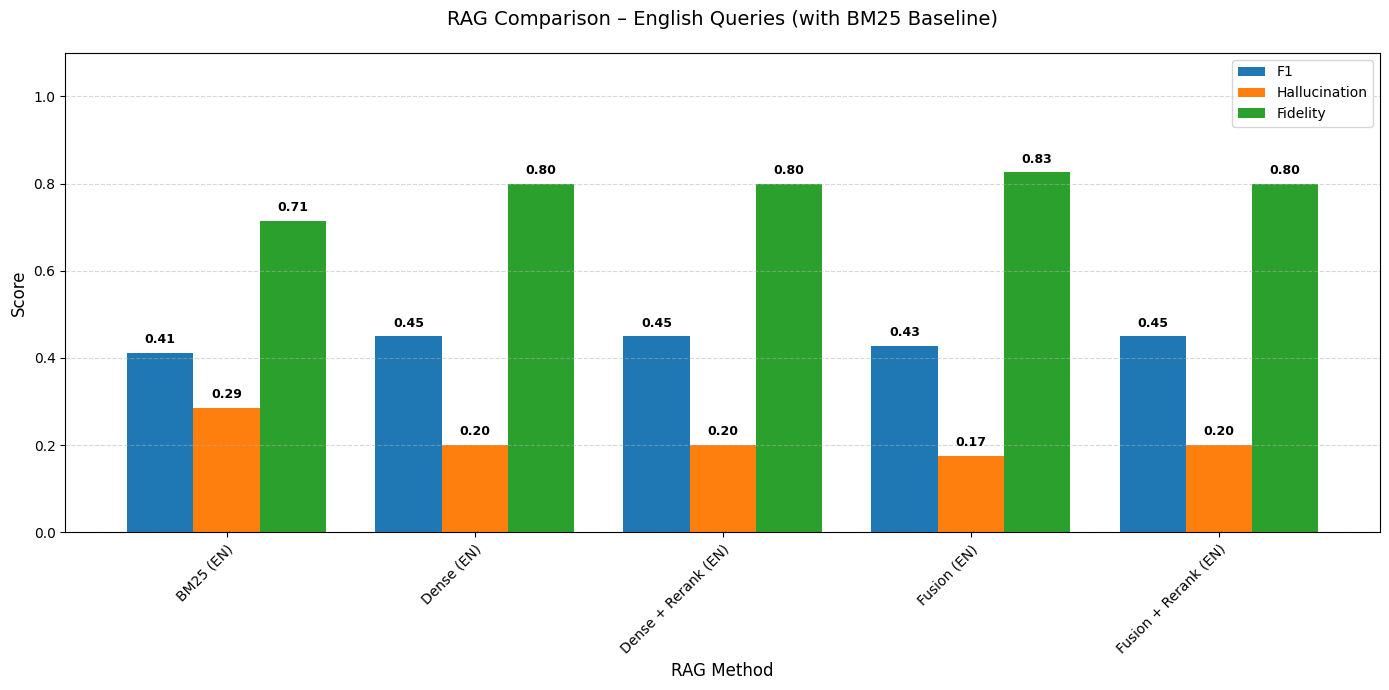

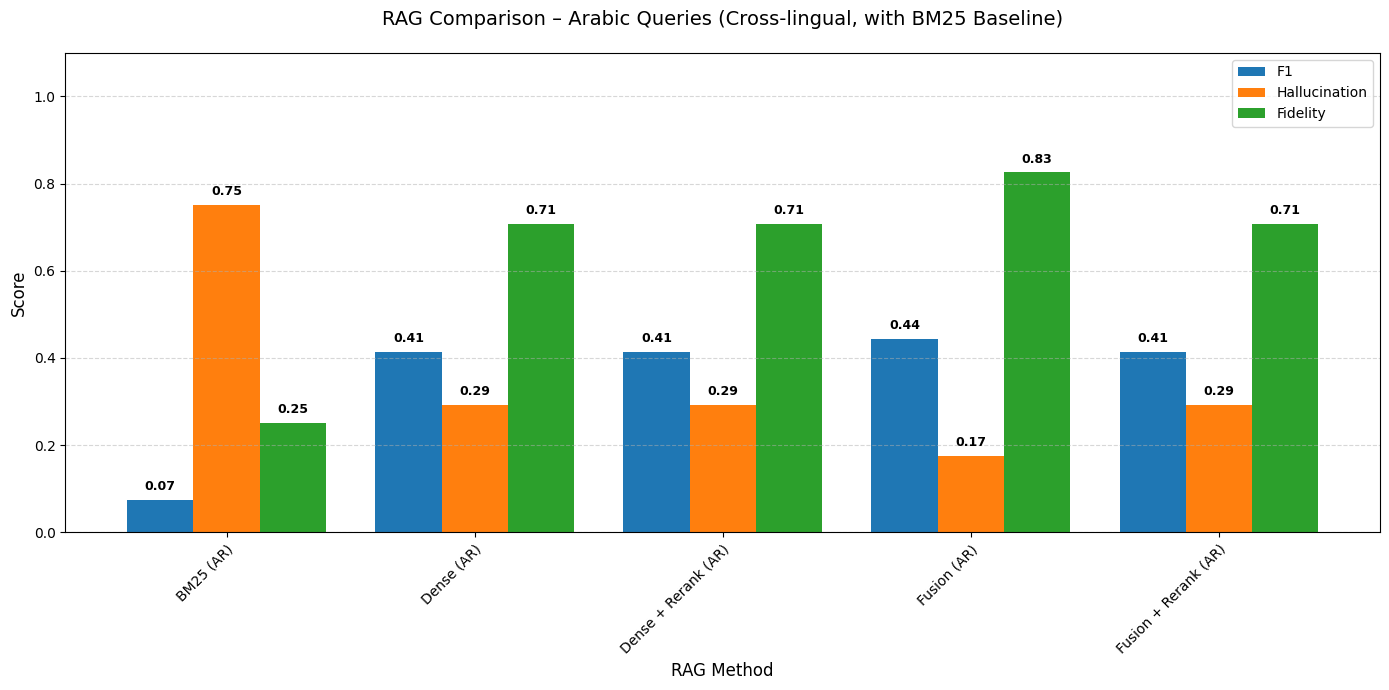

In [ ]:
# ----------------------------
# 14. Visualization (Professional Master's Level Formatting)
# ----------------------------

def format_plot(ax, title):
   # 1. تدوير العناوين بميل 45 درجة لليمين
    plt.setp(ax.get_xticklabels(), rotation=45, ha="right", rotation_mode="anchor")

    # 2. إضافة نسبة كل بار فوقه مباشرة
    for p in ax.patches:
        height = p.get_height()
        if height > 0:
            ax.annotate(f'{height:.2f}',
                         (p.get_x() + p.get_width() / 2., height),
                         ha='center', va='bottom',
                         xytext=(0, 5),
                         textcoords='offset points',
                         fontsize=9,
                         fontweight='bold')

    ax.set_title(title, fontsize=14, pad=20)
    ax.set_ylabel("Score", fontsize=12)
    ax.set_xlabel("RAG Method", fontsize=12)
    ax.grid(axis="y", linestyle="--", alpha=0.5)

# --- English Results ---
df_en = df[["BM25 (EN)", "Dense (EN)", "Dense + Rerank (EN)", "Fusion (EN)", "Fusion + Rerank (EN)"]]

ax1 = df_en.T.plot(kind="bar", figsize=(14, 7), width=0.8, ylim=(0, 1.1))
format_plot(ax1, "RAG Comparison – English Queries (with BM25 Baseline)")

plt.tight_layout()
plt.show()

# --- Arabic Results ---
df_ar = df[["BM25 (AR)", "Dense (AR)", "Dense + Rerank (AR)", "Fusion (AR)", "Fusion + Rerank (AR)"]]

ax2 = df_ar.T.plot(kind="bar", figsize=(14, 7), width=0.8, ylim=(0, 1.1))
format_plot(ax2, "RAG Comparison – Arabic Queries (Cross-lingual, with BM25 Baseline)")

plt.tight_layout()
plt.show()